In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
from jax import numpy as jnp
from ott.solvers.quadratic import gromov_wasserstein
from ott.problems.quadratic import quadratic_problem
from ott.solvers.quadratic import lower_bound
from ott.geometry import pointcloud, costs
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

root_path = Path("../..")
data_path = root_path / "data"

In [4]:
subsampled = jnp.load(data_path / "kmeans_subsampled_n10_s50.npz")
train_indices = np.loadtxt(data_path / "train_indices.txt").astype(int)

In [5]:
pts = subsampled["points"]
wghts = subsampled["weights"]

train_pts = pts[train_indices]
train_wghts = wghts[train_indices]

In [6]:
def preprocess_pts(pts):
    rec_pts = pts - pts.mean(axis=0, keepdims=True)
    norm_pts = rec_pts / 30
    return norm_pts

def gw_distance(pts_a, pts_b, wghts_a, wghts_b, epsilon=2e0):
    cloud_a = pointcloud.PointCloud(preprocess_pts(pts_a), cost_fn=costs.SqEuclidean())
    cloud_b = pointcloud.PointCloud(preprocess_pts(pts_b), cost_fn=costs.SqEuclidean())

    prob = quadratic_problem.QuadraticProblem(cloud_a, cloud_b, a=wghts_a, b=wghts_b)

    solver = gromov_wasserstein.GromovWasserstein(epsilon=epsilon)

    return solver(prob)

t = 0
# soln = gw_distance(pts[5, t], pts[6, t], wghts[5, t], wghts[6, t])
trialed_gw_distance = jax.vmap(gw_distance)
dists_to_pointcloud = jax.jit(jax.vmap(trialed_gw_distance, in_axes=[0, None, 0, None]))
pairwise_dists = jax.jit(jax.vmap(dists_to_pointcloud, in_axes=[None, 0, None, 0]))

def self_pairwise_dists(pts, wghts):
    return pairwise_dists(pts, pts, wghts, wghts)

In [15]:
dist_mat = self_pairwise_dists(train_pts[:7, :], train_wghts[:7, :])

In [16]:
import seaborn as sns
# sns.heatmap(dist_mat.reg_gw_cost[:, :, 1], vmin=0)
# sns.heatmap(jnp.median(dist_mat.reg_gw_cost, -1), vmin=0)
# dist_mat.reg_gw_cost.std(-1)
# dist_mat.reg_gw_cost > 1e3

<Axes: >

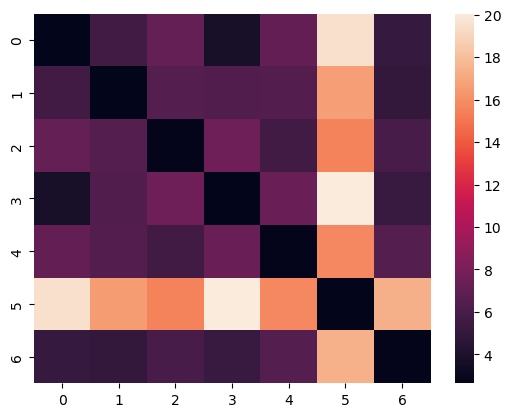

In [17]:
# plt.imshow(dist_mat[5, 0, 0])
sns.heatmap(jnp.sqrt(dist_mat.reg_gw_cost[:, :, 0]))

In [18]:
dist_mat.converged[1,3]
dist_mat.costs[1,3]

Array([[52.414238, 45.48117 , 41.305466, 40.127357, 39.63638 , 39.48509 ,
        39.430267, 39.36915 , 39.34365 , -1.      , -1.      , -1.      ,
        -1.      , -1.      , -1.      , -1.      , -1.      , -1.      ,
        -1.      , -1.      , -1.      , -1.      , -1.      , -1.      ,
        -1.      , -1.      , -1.      , -1.      , -1.      , -1.      ,
        -1.      , -1.      , -1.      , -1.      , -1.      , -1.      ,
        -1.      , -1.      , -1.      , -1.      , -1.      , -1.      ,
        -1.      , -1.      , -1.      , -1.      , -1.      , -1.      ,
        -1.      , -1.      ],
       [52.882782, 47.721478, 43.435524, 42.300636, 41.694546, 41.448677,
        41.2958  , 40.987007, 40.56298 , 40.324688, 40.227943, 40.193405,
        -1.      , -1.      , -1.      , -1.      , -1.      , -1.      ,
        -1.      , -1.      , -1.      , -1.      , -1.      , -1.      ,
        -1.      , -1.      , -1.      , -1.      , -1.      , -1.      ,
       